# Load Dataset 9cmd


In [47]:
import numpy as np
import librosa # mfcc functions
import pandas as pd #reading txt files
import os

sr=16000

In [48]:
diCategories = {
            'yes': 0,
            'no': 1,
            'up': 2,
            'down': 3,
            'left': 4,
            'right': 5,
            'on': 6,
            'off': 7,
            'stop': 8,
            'go': 9}

categoriesFolder=tuple([e+"/" for e in diCategories])
categories=tuple(diCategories)
print(categoriesFolder)

('yes/', 'no/', 'up/', 'down/', 'left/', 'right/', 'on/', 'off/', 'stop/', 'go/')


In [49]:
# Load Dataset filenames
basePath = 'sd_GSCmdV2'

testWAVs = pd.read_csv(basePath + '/train/testing_list.txt',
                           sep=" ", header=None)[0].tolist()
testWAVs = [os.path.join(basePath + '/train/', f + '.npy')
                for f in testWAVs if f.endswith('.wav') and f.startswith(categoriesFolder)]

valWAVs = pd.read_csv(basePath + '/train/validation_list.txt',
                           sep=" ", header=None)[0].tolist()
valWAVs = [os.path.join(basePath + '/train/', f + '.npy')
                for f in valWAVs if f.endswith('.wav') and f.startswith(categoriesFolder)]

allWAVs = []
for root, dirs, files in os.walk(basePath + '/train/'):
    allWAVs += [root + '/' + f for f in files if f.endswith('.wav.npy') and root.endswith(categories)]
trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

print("# of test: ",len(testWAVs))
print("# of val: ",len(valWAVs))
print("# of train: ",len(trainWAVs))
print("# total: ",len(allWAVs))

# of test:  4074
# of val:  3703
# of train:  30769
# total:  38546


In [50]:
# LOAD DATASET FILES
def loadBatch(filesList,batch_size=1000,dim=16000):

    X = np.empty((batch_size, dim))
    y = np.empty((batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(filesList[0:batch_size]):
        # load data from file, saved as numpy array on disk
        curX = np.load(ID)

        # curX could be bigger or smaller than self.dim
        if curX.shape[0] == dim:
            X[i] = curX
        elif curX.shape[0] > dim:  # bigger
            # we can choose any position in curX-self.dim
            randPos = np.random.randint(curX.shape[0]-dim)
            X[i] = curX[randPos:randPos+dim]
        else:  # smaller
            randPos = np.random.randint(dim-curX.shape[0])
            X[i, randPos:randPos + curX.shape[0]] = curX
            # print('File dim smaller')
        
        # Store class
        y[i] = diCategories[os.path.basename(os.path.dirname(ID))]
        
    return X,y

In [58]:
# PREPROCESSING

#12 MFCC + 12 DELTA +12 DELTADELTA
def MFCC_DELTA_12(X,sr=16000):
    features = np.empty((X.shape[0],36,126)) #12*3, ...
    for i,y in enumerate(X):
        S = librosa.feature.melspectrogram(y, sr=sr, n_fft=1024,
                                                hop_length=128, power=1.0, #window='hann',
                                                n_mels=80, fmin=40.0, fmax=sr/2)

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_S = librosa.power_to_db(S, ref=np.max)

        # Next, we'll extract the top 12 Mel-frequency cepstral coefficients (MFCCs)
        mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=12)

        # Let's pad on the first and second deltas while we're at it
        delta_mfcc  = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

        features[i] = np.concatenate((mfcc, delta_mfcc, delta2_mfcc), axis=0)
    return features

Loading  1000  files (seconds): 0.43779611587524414
Size: 128000000 bytes
Transforming  1000  elements (seconds): 4.509008884429932
Size: 36288000 bytes


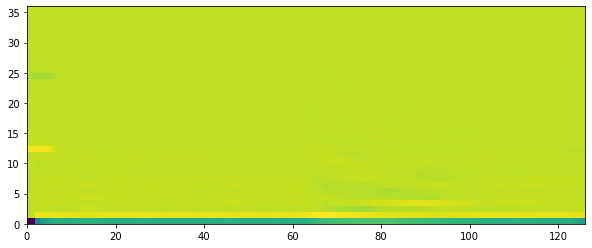

In [61]:
import time
import matplotlib.pyplot as plt

start = time.time()
X,y=loadBatch(valWAVs)
end = time.time()
print("Loading ", 1000, " files (seconds):", end - start)
print("Size: %d bytes" % (X.nbytes))

start = time.time()
features=MFCC_DELTA_12(X)
end = time.time()
print("Transforming ", 1000, " elements (seconds):", end - start)
print("Size: %d bytes" % (features.nbytes))


plt.figure(figsize=(10, 4))
plt.pcolormesh(features[0])
plt.show()

In [46]:
print("ciao")

ciao


In [57]:
print(X.shape[0])

1000
